In [15]:
import torch
import pyro
import json

import matplotlib.pyplot as plt
import pyro.distributions as dist
import numpy as np

from dataset.data_loaders import load_dataset, generate_datasets
from ESN import esnet
from sklearn.metrics import mean_squared_error
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS

# Probabilistic time series forecasting with randomized neural networks


Author: Michele Guerra

Date: 18 November 2022

## Time series data

Hourly electric energy demand time series provided by ACEA

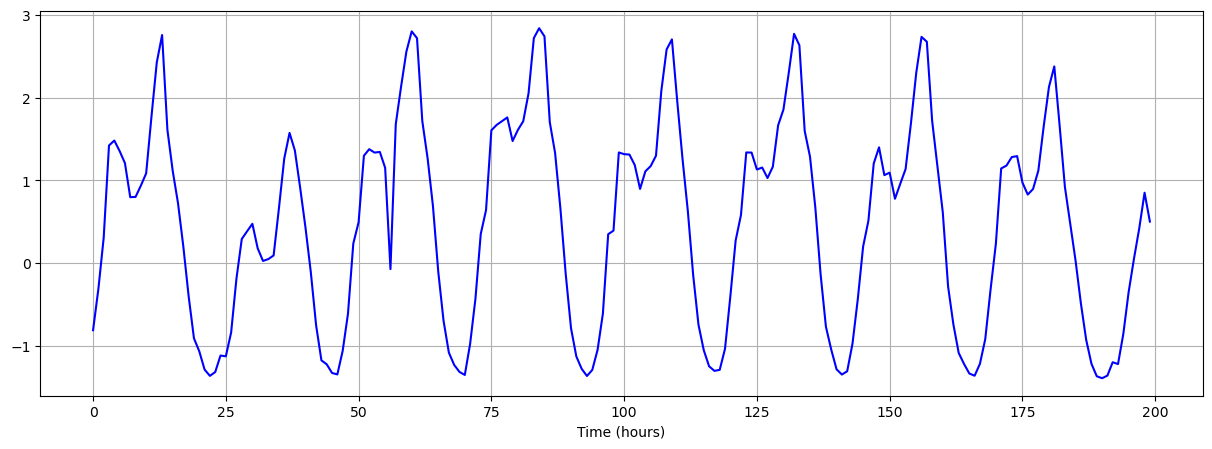

In [2]:
# Load and pre-process dataset
X, Y = load_dataset("acea")
Xtr, Ytr, Xval, Yval, Xte, Yte = generate_datasets(X, Y, test_percent = 0.15, val_percent = 0.15)

# Plot data
fig = plt.figure(figsize=(15,5))
plt.plot(Yte[:200], color='b')
plt.grid()  
plt.xlabel("Time (hours)")
plt.show()

**Forecasting**: given the current energy demand, can we predict how much will be asked tomorrow at the same time?

## Reservoir Computing and ESN

A Reservoir Computing is a Recurrent Neural Network (RNN) with some peculiar features.

It consists of an input layer, a **reservoir** and an output layer.


<div>
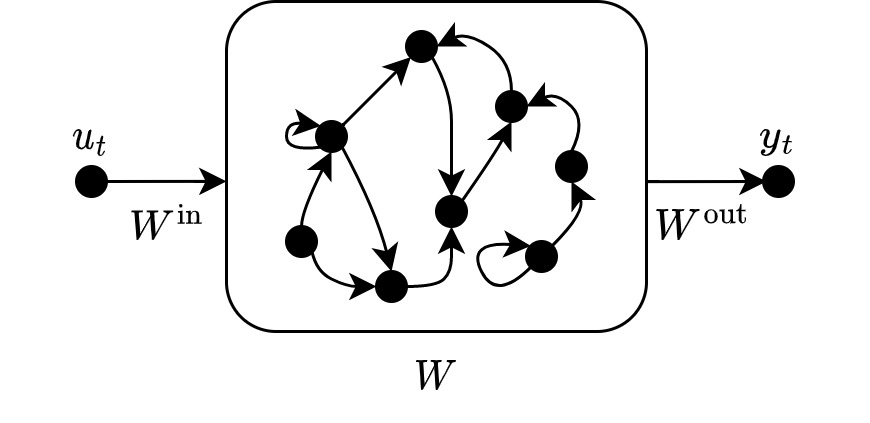
</div>

- Only the output layer is trained
- The input layer and the reservoir are **fixed** at the beginning and never adgjusted afterwards

In formulae
$$
    x_{t+1}=f(Wx_t+W^\text{in}u_{t+1})
$$
$$
    y_t=W^\text{out}x_t
$$

An **Echo State Network (ESN)** is a Reservoir Computing algorithm

It satisfies the **Echo State Property**: the reservoir dynamics will asymptotically forget the initial condition of its state.

Let's build an ESN with:
- $W$ is a $500\times 500$ matrix, 
- its elements are randomly and uniformly drawn in $(-0.5,+0.5)$,
- and it is *sparse*, with a connectivity of $25\%$.

The ESN transforms each input in the input time series into an embedding of dimension 20, and finally the output is produced by training a simple regression layer over those embeddings.

In [3]:
# Set ESN hyperparams
config = json.load(open('ESN/configs/ESN_hyperparams.json', 'r'))

# Train and compute embeddings and predictions
Yte_pred, _, _, train_embedding, _, val_embedding, _, test_embedding = esnet.run_from_config_return_states(Xtr, Ytr, 
                                                                                                            Xte, Yte, 
                                                                                                            config, 
                                                                                                            validation=True,
                                                                                                            Xval=Xval,
                                                                                                            Yval=Yval)

In [4]:
dtype = 'float32'
train_embedding = train_embedding.astype(dtype)
train_embedding = torch.from_numpy(train_embedding)
val_embedding = val_embedding.astype(dtype)
val_embedding = torch.from_numpy(val_embedding)
test_embedding = test_embedding.astype(dtype)
test_embedding = torch.from_numpy(test_embedding)
Ytr = Ytr.astype(dtype).squeeze()
Ytr = torch.from_numpy(Ytr)

We can now plot the predictions produced by our ESN and compare them with the actual values provided by ACEA

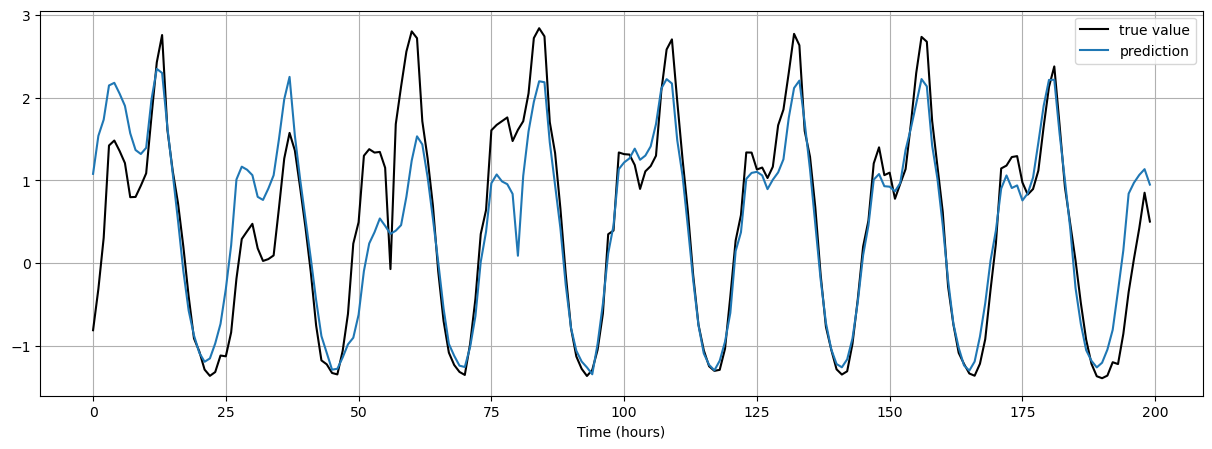

Test MSE 0.203


In [5]:
# Plot results
fig = plt.figure(figsize=(15,5))
plt.plot(Yte[:200], label='true value', color='k')
plt.plot(Yte_pred[:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.xlabel("Time (hours)")
plt.show()

# Mean square error of the prediction
print('Test MSE {:.3f}'.format(mean_squared_error(Yte_pred, Yte)))

## Uncertainty

The ESN we trained above is making **deterministic** forecasts

What if we pass to it an input that lies quite away from the data that it was trained with?

It will still produce an output, but how do we know how likely that output is? 

In other words, how do we know how confident is our network when predicting that value?

There are two sources of **uncertainties** in Deep Learning:
- An **aleatoric uncertainty**, reflecting the noise coming from the data itself
- A **model uncertainty**, which arises in two possible ways:
    * an uncertainty related to model's parameters
    * an uncertainty coming from the model's structure itself

We want to quantify how much the above sources of uncertainty affect the prediction.

One way to do this is with **Bayesian models**.

## Bayesian models

With Bayesian Neural Networks parameters in the model are described by **probability distributions**.

The model itself is then described by a probability distribution
$$p(x,y,\omega)=p(x,y|\omega)p(\omega).$$

From this, we can ask a number of interesting questions:
- What is the distribution of parameters given the data, $p(\omega|x,y)$?
- Can we sample new data from $p(y'|x,y)$?

Computing analytically the above distributions so to answer to those questions is very often impossible, but we can tackle the challenge with two methods: 
- **Variational Inference**
- **Monte Carlo Markov Chain**.

Let's do this in our setting: we substitute a deterministic linear layer, defined with...

In [6]:
torch_model = torch.nn.Linear(20, 1)

... with a probabilistic model using Pyro library

<div>
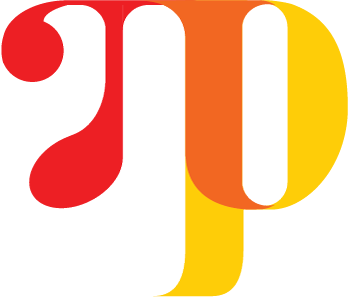
</div>

In [8]:
class BayesianRegression(PyroModule):
    def __init__(self, torch_model):
        super().__init__()
        
        pyro.nn.module.to_pyro_module_(torch_model)
        self.model = torch_model
        
        for m in self.model.modules():
            for name, value in list(m.named_parameters(recurse=False)):
                setattr(m, name, PyroSample(dist.Normal(0., 1.).expand(value.shape).to_event(value.dim())))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.model(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

model = BayesianRegression(torch_model)

### Stochastic Variational Inference



The idea of SVI consists of using a
- **variational distribution** $q_\lambda(\omega)$ to approximate the true posterior $p(\omega|x,y)$, and
- searching for the best parameter $\lambda$ that minimizes the "difference" between $q_\lambda(\omega)$ and $p(\omega|x,y)$ 

![SVIUrl](https://cdn.codeground.org/nsr/images/img/researchareas/ai-article9_02.gif "SVI")

In [12]:
# Define the variational distribution
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

In [13]:
# Train the variational distribution
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_iterations = 120

# pyro.clear_param_store() # why do we need to clear the param store first?
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(train_embedding, Ytr)
    if j % 20 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / Ytr.shape[0]))

guide.requires_grad_(False)

[iteration 0001] loss: 2.6076
[iteration 0021] loss: 2.1706
[iteration 0041] loss: 1.7478
[iteration 0061] loss: 1.2327
[iteration 0081] loss: 0.8030
[iteration 0101] loss: 0.6458


AutoMultivariateNormal()

In [22]:
# Make predictions
predictive_svi = Predictive(model, guide=guide, num_samples=1000, 
                        return_sites=("obs", "_RETURN"))(x=test_embedding, y=None)

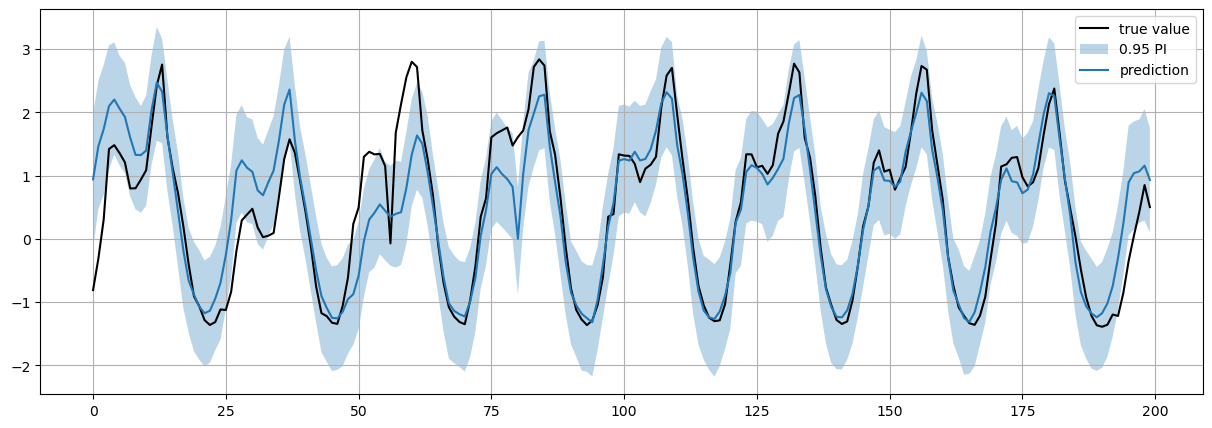

In [19]:
# Aleatoric uncertainty
# Draw results with 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive_svi["obs"].numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive_svi["obs"].numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[:200], label='true value', color='k')
plt.fill_between(np.arange(200), q_low[:200], q_hi[:200], alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean[:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

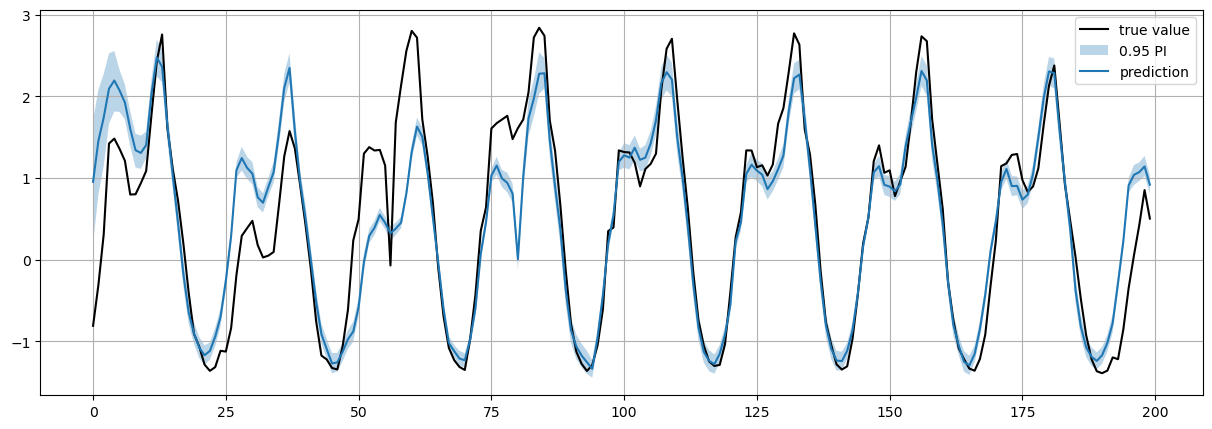

In [23]:
# Model uncertainty
# Draw results with 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive_svi["_RETURN"].numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive_svi["_RETURN"].numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[:200], label='true value', color='k')
plt.fill_between(np.arange(200), q_low[:200], q_hi[:200], alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean[:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

### Monte Carlo Markov Chain

MCMC algorithms approximate the true posterior $p(\omega|x,y)$

1. you start from a value $\omega_0$
2. propose a new state $\tilde{\omega}$ according to a *transition matrix* $H_{ij}=P(\tilde{\omega}=j|\omega_n=i)$
3. sample $u$ from a uniform distribution
4. compute the acceptance probability $a_{ij}=\min\left(1,\frac{p(\omega=j|x,y) H_{ji}}{p(\omega=i|x,y)H_{ij}}\right)$
5. accept the proposal state if $u<a_{ij}$

It can be shown that this iterative process converges to the posterior $p(\omega|x,y)$.

[LINK](https://chi-feng.github.io/mcmc-demo/app.html)
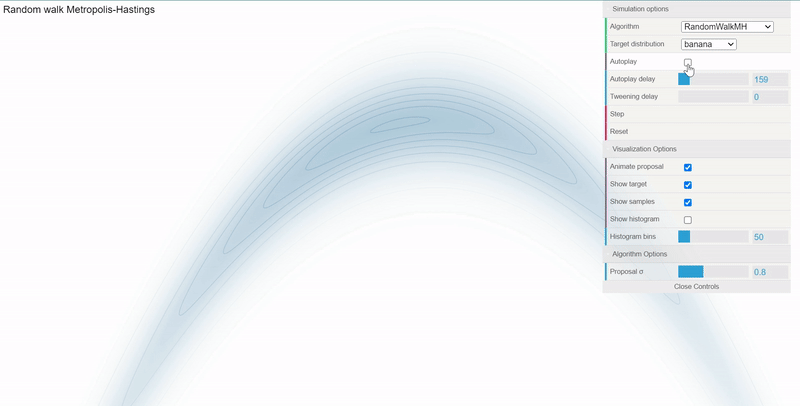

In [ ]:
# Run the MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1500, warmup_steps=500, num_chains=1)
mcmc.run(train_embedding, Ytr)

# Sample from the posterior
samples = mcmc.get_samples()

In [24]:
# Make predictions
predictive_mcmc = Predictive(model, samples, 
                        return_sites=("obs", "_RETURN"))(x=test_embedding, y=None)

Sample: 100%|███████████████████████████████████████| 2000/2000 [01:22, 24.29it/s, step size=4.88e-01, acc. prob=0.896]


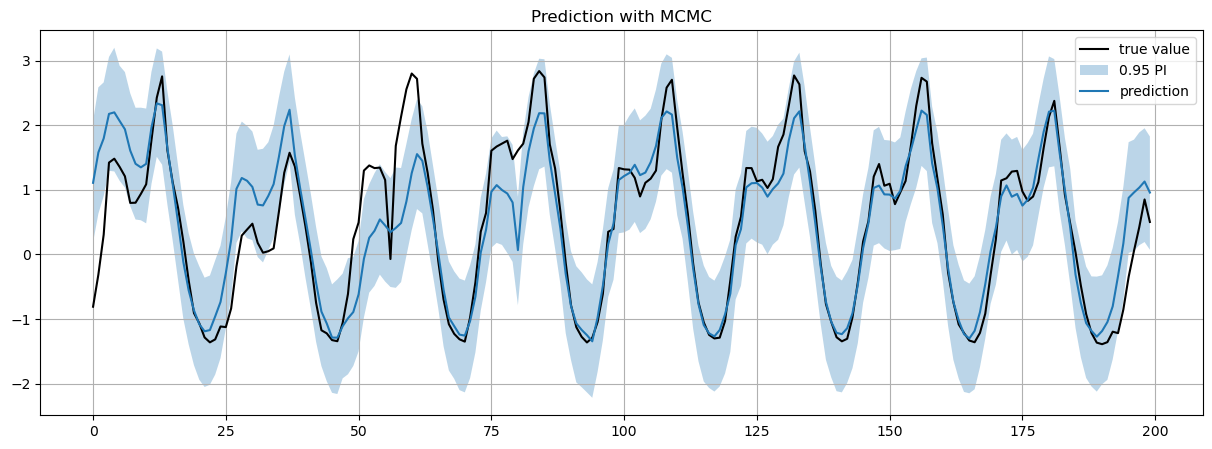

In [21]:
# Aleatoric uncertainty
# Draw results with 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive_mcmc["obs"].numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive_mcmc["obs"].numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[:200], label='true value', color='k')
plt.fill_between(np.arange(200), q_low[:200], q_hi[:200], alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean[:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.title("Prediction with MCMC")
plt.show()

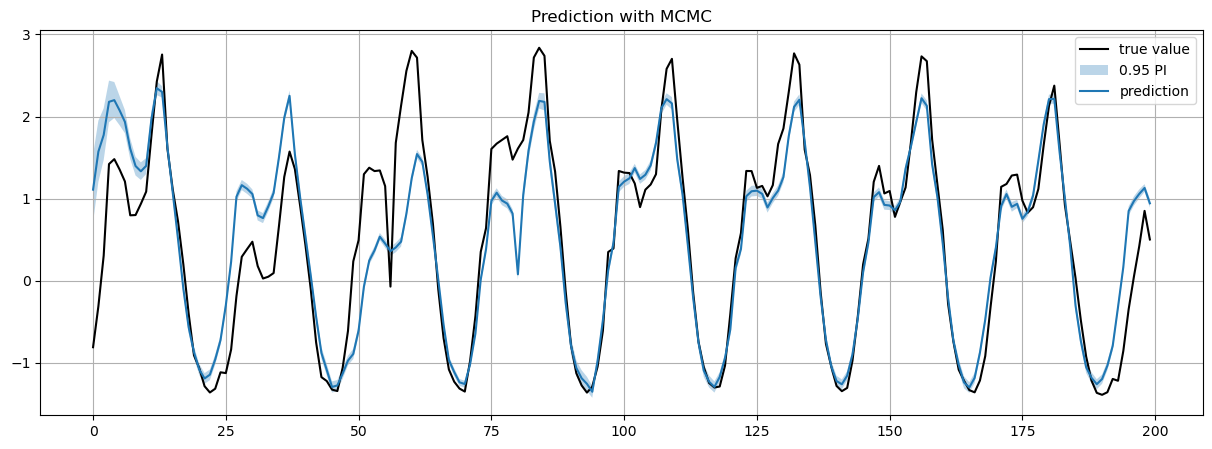

In [25]:
# Model uncertainty
# Draw results with 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive_mcmc["_RETURN"].numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive_mcmc["_RETURN"].numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[:200], label='true value', color='k')
plt.fill_between(np.arange(200), q_low[:200], q_hi[:200], alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean[:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.title("Prediction with MCMC")
plt.show()

### SVI vs MCMC

| SVI | MCMC |
| :-: | :-: |
|biased | unbiased |
|optimisation process | sampling process |
|fast computing | computationally intensive |
|larger datasets | smaller datasets |


## Research topics



- Compare Bayesian and frequentist approaches to uncertainty estimations

- Compare SVI and MCMC

- Assess output miscalibration

- Extend to other types of data (graphs)

- Compare RC with other forecasting models

Thanks for your attention!